# Data Homework @ DoorDash

This notebook describes steps including data preprocessing and building ML models to predict delivery time.

The delivery time is the target variable and it is **supervised** learning. The delivery time spent (in sec) is numeric and continous so I will deal with this problem using **regression** models. 

Note that, all the events in **predict_data.csv** (from 2015-02-18 to 2015-02-25) are later than **historical_data.csv** (from 2014-10-19 to 2015-02-18). Therefore, when I am building ML models and doing model selection, I consider `out-of-time` data, i.e. 20% chronologically later events, for validation.

Since it is a regression problem, I used metrics **Mean-Absolute-Errors (MAE)** and **Root-Squared-Mean-Errors (RMSE)**.  

The table of content:

* A. Data Preprocess

    * A.1 Create target variable - 'spent_time'
    * A.2 Outliers
    * A.3 Categorical variable - 'store_primary_category'
    * A.4 Missing value
   
* B. Feature Visualization
* C. Regression Model
    * C.1 Linear model - Lasso (Baseline)
    * C.2 Random forest regressor
    * C.3 Deep neural networks
    * C.4 Gradient boosting machine 
    * C.5 Revised gradient boosted machine
    * C.6 Model comparison
* D. Prediction


Also note there are missing values in **predict_data.csv**, so we have to impute missing values in the data.

By model comparison, the optimal regression model is given by gradient boosting machine (GBM) with tree regressor, and I used it to generated prediction of **predict_data.csv** and saved in **data_to_predict_gbm.csv**. 

However, I also tried the revised GBM, which additionally considers a coefficent to adjust under-estimated delivery time in the cost. Though overall GBM still outperforms rGBM, the later lowers the impact under-estimated delivery time (but higher over-estimated delivery time). I also generated prediction and saved in **data_to_predict_gbm2.csv** for reference.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import pylab

import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

In [2]:
df = pd.read_csv("historical_data.csv")
pred_df = pd.read_csv("predict_data.csv")
df.shape, pred_df.shape

((197428, 16), (54778, 17))

In [4]:
df["created_at"].min(), df["created_at"].max(), pred_df["created_at"].min(), pred_df["created_at"].max()

('2014-10-19 05:24:15',
 '2015-02-18 06:00:44',
 '2015-02-18 14:50:28',
 '2015-02-25 05:59:49')

In [3]:
df = df.sort_values(by=['created_at'])

In [4]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0
43519,1.0,2015-01-21 15:22:03,2015-01-21 16:17:43,2966,dessert,4.0,2,1058,2,219,799,2.0,1.0,1.0,251,463.0
148754,3.0,2015-01-21 15:31:51,2015-01-21 16:16:34,1303,cafe,4.0,2,690,2,195,255,2.0,0.0,1.0,251,458.0
187014,1.0,2015-01-21 15:39:16,2015-01-21 15:58:11,5551,NaN,4.0,3,1867,3,449,529,4.0,1.0,1.0,251,284.0
10265,1.0,2015-01-21 15:40:42,2015-01-21 16:22:37,602,cafe,4.0,3,955,3,245,345,3.0,2.0,2.0,251,377.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197428 entries, 2690 to 61787
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                

## A. Data Preprocess

### A.1 Create target variable - 'spent_time'

Given `created_at` and `actual_delivery_time` columns, I made the target variable `spent_time`, which is the delivery time by `actual_delivery_time` - `created_at`. Meanwhile, I also created columns `month`, `day`, `hour` and `workday` from `created_at`. For example, "2015-02-06 22:24:17" will give `month`=2, `day`=6, `hour`=22 and `min`=24. The `workday` = $\lbrace 0, 1, \cdots, 6\rbrace$ represent Sunday, Monday...

Here I do not create year since only one data point in 2014, and it is an outlier and will be removed later.

In [5]:
def get_time_features(df):
    # take month, day, hour, min from created_at:
    df["month"] = df.apply(lambda x: int(x["created_at"].split(" ")[0].split("-")[1]), axis=1)
    df["day"] = df.apply(lambda x: int(x["created_at"].split(" ")[0].split("-")[2]), axis=1)
    df["hour"] = df.apply(lambda x: int(x["created_at"].split(" ")[1].split(":")[0]), axis=1)
    df["min"] = df.apply(lambda x: int(x["created_at"].split(" ")[1].split(":")[1]), axis=1)
    
    # take weekday information
    df['weekday'] = df.apply(lambda x: x["created_at"].split(" ")[0], axis=1)
    df['weekday'] = pd.to_datetime(df['weekday'], errors='coerce')
    df['weekday'] = df['weekday'].dt.dayofweek
    
    df = df.drop(['created_at'], axis=1)
    
    return df

def get_spent_time_for_delivery(df):
    ''' 
    get target value: actual_deliver_time - created_at 
    ''' 
    df['ts1'] = df['created_at'].apply(lambda x: pd.Timestamp(x).timestamp())
    df['ts2'] = df['actual_delivery_time'].apply(lambda x: pd.Timestamp(x).timestamp())
    df['spent_time'] = pd.Series(df['ts2']-df['ts1'], index = df.index)
    
    df = df.drop(['ts1', 'ts2'], axis=1)
    
    return df

In [6]:
df = df.dropna(axis=0, subset=['created_at', 'actual_delivery_time'])
df = get_spent_time_for_delivery(df)
df = df.drop(['actual_delivery_time'], axis=1)

df = get_time_features(df)

In [8]:
df.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,spent_time,month,day,hour,min,weekday
2690,1.0,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0,8516859.0,10,19,5,24,6
43519,1.0,2966,dessert,4.0,2,1058,2,219,799,2.0,1.0,1.0,251,463.0,3340.0,1,21,15,22,2
148754,3.0,1303,cafe,4.0,2,690,2,195,255,2.0,0.0,1.0,251,458.0,2683.0,1,21,15,31,2
187014,1.0,5551,NaN,4.0,3,1867,3,449,529,4.0,1.0,1.0,251,284.0,1135.0,1,21,15,39,2
10265,1.0,602,cafe,4.0,3,955,3,245,345,3.0,2.0,2.0,251,377.0,2515.0,1,21,15,40,2


### A.2 Outliers

There seem three different months in data, but only one data point for Oct. 2014. It is an outlier in `spent_time`. In visualizing boxplot: `spent time` vs `month` and histgram on `spent time`, we can see three data points, whose `spent_time` > 100000 sec (~ 27 hours). Thus these are outliers and I will remove from data (including the event is in 2014 Oct).

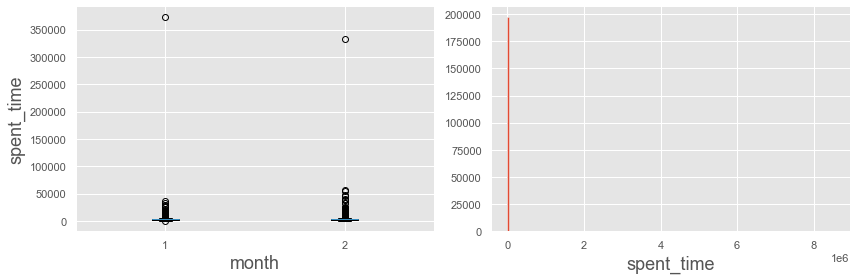

In [9]:
plt.figure(figsize = (12,4), tight_layout=True)

plt.subplot(121)  
plt.boxplot([df[df.month==1]['spent_time'].tolist(), df[df.month==2]['spent_time'].tolist()])
plt.xlabel('month', fontsize=18)
plt.ylabel('spent_time', fontsize=18)

plt.subplot(122)
plt.hist(df['spent_time'], bins=200)
plt.xlabel('spent_time', fontsize=18)

plt.show()

In [7]:
outliers = df[df.spent_time > 100000]
df = df[df.spent_time < 100000]

The outlier events are shown below:

In [11]:
outliers.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,spent_time,month,day,hour,min,weekday
2690,1.0,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0,8516859.0,10,19,5,24,6
185550,4.0,6503,dessert,5.0,3,1520,3,220,750,0.0,0.0,0.0,251,476.0,373879.0,1,28,8,34,2
27189,1.0,4338,indian,3.0,4,4980,4,995,1795,72.0,68.0,104.0,251,767.0,332482.0,2,16,2,24,0


After removing the outliers, the data look better:

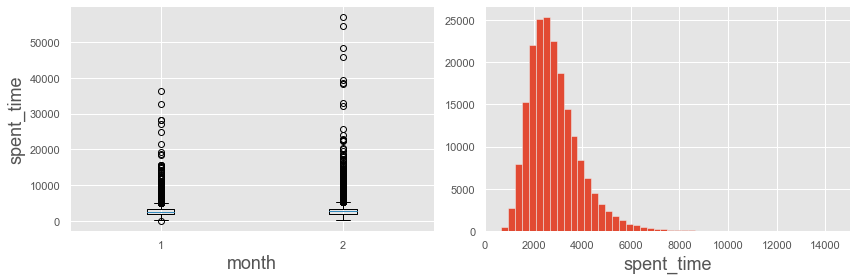

In [8]:
plt.figure(figsize = (12,4), tight_layout=True)
        
plt.subplot(121)  
plt.boxplot([df[df.month==1]['spent_time'].tolist(), df[df.month==2]['spent_time'].tolist()])
plt.xlabel('month', fontsize=18)
plt.ylabel('spent_time', fontsize=18)

plt.subplot(122)
plt.hist(df['spent_time'], bins=200)
plt.xlabel('spent_time', fontsize=18)
plt.xlim(0, 15000)

plt.show()

### A.3 Categorical variable - 'store_primary_category'

Use `LabelEncoder` to convert `store_primary_category` to number label:

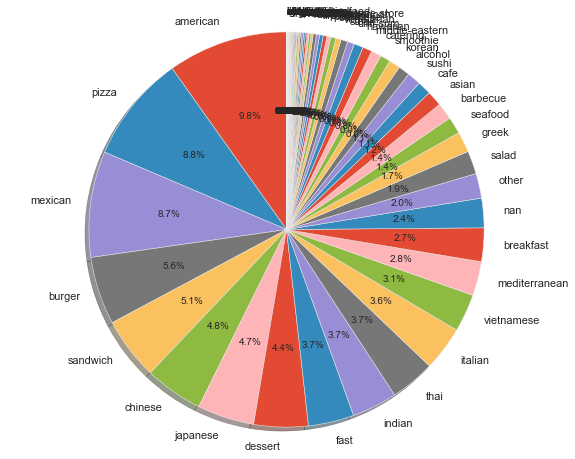

In [13]:
def pieChart(data):
    c_dict = {}
    for x in data:
        c_dict[x] = c_dict.get(x, 0) + 1
        
    c_dict = sorted(c_dict.items(), key=lambda x: x[1], reverse=True)
    
    labels = [c[0] for c in c_dict]
    sizes = [c[1]/len(data) for c in c_dict]
    
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    
pieChart(df["store_primary_category"])

In [9]:
from sklearn.preprocessing import LabelEncoder
store_category_encoder = LabelEncoder()
df["store_primary_category"] = store_category_encoder.fit_transform(df["store_primary_category"])

### A.4 Missing value

Next check missing values. There are some missing values in the fields: `market_id`, `order_protocol`, `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`, and `estimated_order_place_duration` in the data.

`market_id` and `order_protocol` are like id, so we use `LabelEncoder` and keep them for later converting in **predict_data.csv**. Missing values in other fields are filled by their **median values**.

In [15]:
df.isnull().sum()

market_id                                         987
store_id                                            0
store_primary_category                              0
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16261
total_busy_dashers                              16261
total_outstanding_orders                        16261
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
spent_time                                          0
month                                               0
day                                                 0
hour                                                0
min                         

#### a. 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'

Compute the **median** values of these attributes and later fill in missing values of these fields in **predict_data.csv**.

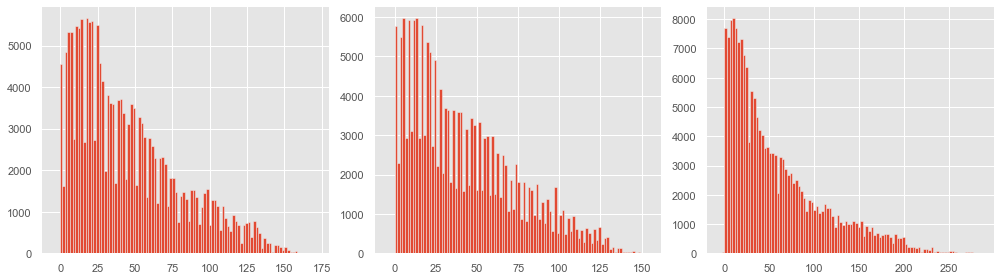

In [25]:
fig, axs = plt.subplots(1, 3, figsize = (14,4), tight_layout=True)

axs[0].hist(df['total_onshift_dashers'].dropna(), bins=100)
axs[1].hist(df['total_busy_dashers'].dropna(), bins=100)
axs[2].hist(df['total_outstanding_orders'].dropna(), bins=100)

plt.show()

#### b. 'order_protocol'

Keep order_protocol_encoder and later convert `order_protocol` in **predict_data.csv**.

In [10]:
order_protocol_encoder = LabelEncoder()
df["order_protocol"] = order_protocol_encoder.fit_transform(df["order_protocol"])

In [27]:
set(df["order_protocol"])

{0, 1, 2, 3, 4, 5, 6, 7}

#### c. 'market_id'

Keep market_id_encoder and later convert `market_id` in **predict_data.csv**.

In [11]:
market_id_encoder = LabelEncoder()
df["market_id"] = market_id_encoder.fit_transform(df["market_id"])

In [29]:
set(df['market_id'])

{0, 1, 2, 3, 4, 5, 6}

#### d. 'estimated_store_to_consumer_driving_duration'

Compute the **median** values of these attributes and later fill in missing values in **predict_data.csv**.

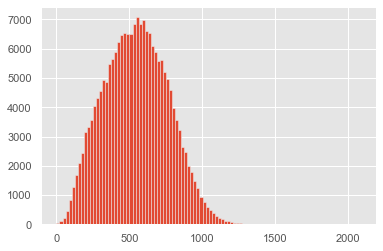

In [18]:
plt.hist(df['estimated_store_to_consumer_driving_duration'], bins=100)
plt.show()

Finally I imputate the missing values of 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders' by fill their corresponding median value:

In [12]:
fillna_values = {'total_onshift_dashers': df['total_onshift_dashers'].dropna().median(),
          'total_busy_dashers': df['total_busy_dashers'].dropna().median(),
          'total_outstanding_orders': df['total_outstanding_orders'].dropna().median(), 
          'estimated_store_to_consumer_driving_duration': df['estimated_store_to_consumer_driving_duration'].dropna().median()}

df2 = df.fillna(value=fillna_values)

In [13]:
df2.isnull().sum()

market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
spent_time                                      0
month                                           0
day                                             0
hour                                            0
min                                             0
weekday                                         0


## B. Feature Visualization

This session is used to visualize: (1) what attributes are highly correlated to the target variable (2) what attributes are highly correlated to each other? 

The former is used to understand data when building model, and the later helps us understand multicollinearity issue. When we are interpreting feature importance, we need to reduce highly correlated attributes to a representative one by dropping others or deploying PCA. 

### B.1 Pearson's correlation between attributes and target variables 


In [35]:
corr = df.drop(['market_id', 'store_id', 'store_primary_category'], axis=1).dropna().corr()

In [36]:
features = corr['spent_time'].keys()
pd.DataFrame({'attribute': [f for f in features], 'corr': [corr['spent_time'][f] for f in features]}).sort_values(by=['corr'], ascending=False)

,attribute,corr
11,spent_time,1.000000
10,estimated_store_to_consumer_driving_duration,0.224868
2,subtotal,0.203930
8,total_outstanding_orders,0.173720
3,num_distinct_items,0.149772
5,max_item_price,0.125453
1,total_items,0.111312
9,estimated_order_place_duration,0.099294
7,total_busy_dashers,0.086847
6,total_onshift_dashers,0.067593


Surprisingly, I thought the delivery time spent will be highly dependent on if it is weekend, but it is only relevant to hours.

### B.2 Visualize highly correlated feature sets

The entire correlation matrix is as follows:

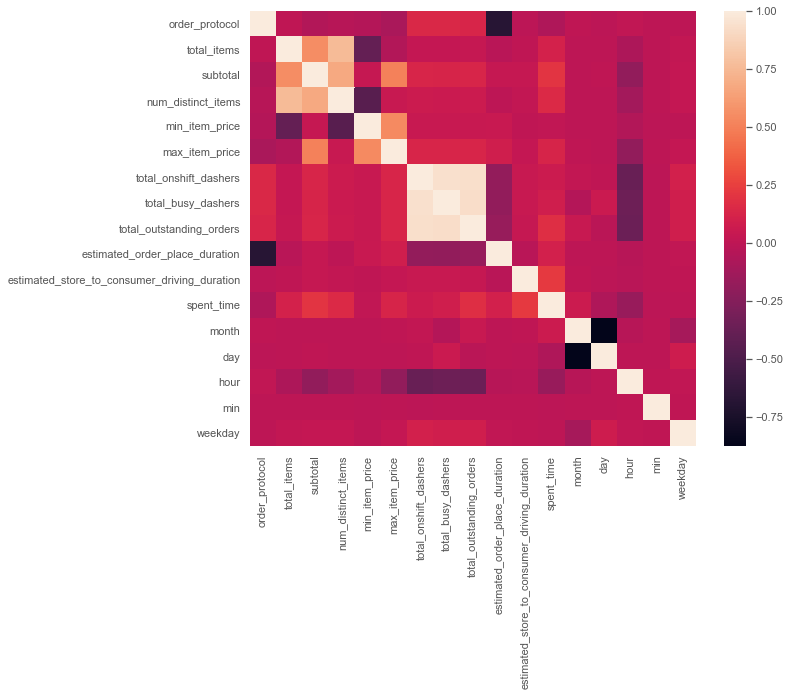

In [665]:
plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr)

The followings are sets of highly correlated features in the dataset:

1. {`total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`}:

In [654]:
print ('corr(total_onshift_dashers, total_busy_dashers):', corr['total_onshift_dashers']['total_busy_dashers'])
print ('corr(total_onshift_dashers, total_outstanding_orders):', corr['total_onshift_dashers']['total_outstanding_orders'])
print ('corr(total_busy_dashers, total_outstanding_orders):', corr['total_busy_dashers']['total_outstanding_orders'])

corr(total_onshift_dashers, total_busy_dashers): 0.9437474945801065
corr(total_onshift_dashers, total_outstanding_orders): 0.9361700036941382
corr(total_busy_dashers, total_outstanding_orders): 0.9329239953620025


2. {`total_items`, `subtotal`, `num_distinct_items`}:

In [656]:
print ('corr(total_items, subtotal):', corr['total_items']['subtotal'])
print ('corr(total_items, num_distinct_items):', corr['total_items']['num_distinct_items'])
print ('corr(subtotal, num_distinct_items):', corr['subtotal']['num_distinct_items'])

corr(total_items, subtotal): 0.5570585894626053
corr(total_items, num_distinct_items): 0.7594561578276906
corr(subtotal, num_distinct_items): 0.6814599301394307


In [659]:
[round(np.mean(df1[df1.weekday==weekday]['spent_time'].tolist()), 3) for weekday in range(7)]

[3090.761, 2779.844, 2652.96, 2826.105, 2684.771, 3005.173, 2909.966]

Therefore, when need model interpretation in linear mdoel, I will simply leave one attribute among `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`, to avoid multicollinearity. 

## C. Regression Model

This session is dedicated to build various ML models. 

As described at the beginning, since all the events in **predict_data.csv** are chronologicallly later than **historical_data.csv**, I took the later 20% out-of-time data from **historical_data.csv** for validation, rather than randomly selecting in-time for validation. For model comparison, I chose MAE (mean-absolute-error) and RMSE (rooted-mean-squared-error)

$$ \textrm{MAE} = \frac{1}{N}\sum^N_{i=1}|y_i-\hat{y}_i|, $$ 

$$\textrm{RMSE} = \sqrt{\frac{1}{N}\sum^N_{i=1}(y_i-\hat{y}_i)^2},$$ 

as metrics for validation. Lower MAE and RMSE means a better model. 

During the model exploration, I also check $R^2$. Generically, high $R^2$ means a better model, but upon increasing number of attributes used in models $R^2$ always increases. Thus I mainly select model by MAE and RMSE.

I will use the following models:

* C.1 Linear model $-$ Lasso (baseline)
* C.2 Random Forest Regressor
* C.3 Neural networks
* C.4 Gradient Bboosted machine 
* C.5 Revised gradient boosted machine

During training tree models, I found optimization with `criterion` = **mse** is much faster than using **mae**. Therefore I will stick using **mse** to optmize the cost function throughout training ML models.

In [14]:
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

def MAE(true_y, pred_y):
    return np.mean([abs(true_y[i]-pred_y[i]) for i in range(len(pred_y))])

def RMSE(true_y, pred_y):
    return np.sqrt(np.mean([(true_y[i]-pred_y[i])**2 for i in range(len(pred_y))]))

### C.0 Training-Test Data split

In [15]:
train, test = df2[:int(0.8*len(df2))], df2[int(0.8*len(df2)):]

X_train, X_test = train.drop(["spent_time"], axis=1), test.drop(["spent_time"], axis=1)
y_train, y_test = train["spent_time"], test["spent_time"]

print (X_train.shape, y_train.shape)

y_test = y_test.tolist()

(157934, 19) (157934,)


In [16]:
X_test.shape, len(y_test), type(y_test)

((39484, 19), 39484, list)

In [17]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

### C.1 Linear model - Lasso

First I built Lasso model (linear regression + $L_1$ regularization) for baseline model. Here I first  standardize the data and then use the standardized data to manually tune the model with different regularization strength $\lambda$:

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

| $\lambda$ |      0.1|  1 | 5 | 10 | 20| 
| :-: |    :-: |  :-: | :-: | :-: |:-: | 
| $R^2$ |     0.163 | 0.166 | 0.180 | 0.186 | 0.174  |  
| MAE |       720.2 | 719.9 | 721.5 | 727.9 | 732.3 |  
| RMSE |      1108.1 | 1105.5  | 1096.6 | 1092.6 | 1100.2 | 

#### Lasso grid search

The following grid searches on regularization strength with 10-fold cross validation. It shows the best model is given around $\lambda$ = 4.

In [19]:
lasso = linear_model.Lasso()
parameters = {'alpha': range(1, 20)}
lasso = GridSearchCV(lasso, parameters, cv=10)
lasso.fit(X_train_std, y_train)
lasso.score(X_test_std, y_test), MAE(y_test, lasso.predict(X_test_std)), RMSE(y_test, lasso.predict(X_test_std))

(0.17712296295229712, 720.6045415498229, 1098.4374802001407)

In [20]:
lasso.best_estimator_

Lasso(alpha=4)

#### feature importance

The following shows attribute importance to the linear model. The top positive contribution are `estimated_store_to_consumer_driving_duration` and `subtotal`; `hour` is a top negative contribution to the model. This observation is consistent with that from Pearson's correlation.

In [110]:
train2 = df2[:int(0.8*len(df2))].drop(["total_onshift_dashers", "total_outstanding_orders", "market_id", "store_id"], axis=1).sample(frac=1)
X_train2, y_train2 = train2.drop(["spent_time"], axis=1), train2["spent_time"]

scaler2 = StandardScaler()
X_train_std2 = scaler2.fit_transform(X_train2)

lasso = linear_model.Lasso(alpha=4.0, random_state=10)
lasso.fit(X_train_std2, y_train2)
coeff =  list(lasso.coef_)

In [111]:
feature_importance = pd.DataFrame({'attribute': list(df2.drop(["total_onshift_dashers", "total_outstanding_orders", "spent_time", "market_id", "store_id"], axis=1).columns),
                                 'coefficient': coeff})
feature_importance.sort_values(by=['coefficient'])

,attribute,coefficient
11,day,-177.287696
12,hour,-118.198375
10,month,-105.955880
14,weekday,-15.980883
13,min,-1.998721
1,order_protocol,0.000000
5,min_item_price,0.000000
2,total_items,1.907811
0,store_primary_category,2.597575
6,max_item_price,13.858532


### C.2 Random Forest Regressor

Second I used random forest regressor. For randome forest, I manually tune two important hyperparameters: (a) **max_depth** and (b) **n_estimators** to see how the hyperparameters are related to $R^2$, MAE and RMSE:

In [46]:
rfReg = RandomForestRegressor(n_estimators=18, max_depth=15, n_jobs=-1, random_state=100, verbose=0, warm_start=False, criterion='mse')
rfReg.fit(X_train, y_train)
rfReg.score(X_test, y_test), MAE(y_test, rfReg.predict(X_test)), RMSE(y_test, rfReg.predict(X_test))

(0.18201023967405128, 710.9170653437151, 1095.1706721162914)


#### a. max_depth 

Following table is $R^2$, MAE and RMSE at various depth using all features:
 
 
| depth | 5 | 10 | 15 |  20 | 25 | 30 | 
| :-: | :-: | :-: | :-: |  :-: | :-: | :-: | 
| $R^2$ | 0.121 | 0.161 | 0.184 | 0.189 | 0.184 | 0.185 |
| MAE | 754.1 | 722.3 | 710.1 | 712.0 | 716.0 | 716.7 |
| RMSE | 1135.4 | 1109.0 | 1093.7 | 1090.8 | 1093.6 | 1093.4 |
 
 
Here we can see the optimal depth is around 15-25. There is overfitting for deeper trees (depth > 25) whereas underfitting for shallow trees (depth < 10).

#### b. n_estimators

Following table is $R^2$, MAE and RMSE at various n_estimators using depth=15:

| n_estimators | 10 | 12 | 14 | 16 | 18 |
| :-: | :-: | :-: | :-: | :-: | :-: | 
| $R^2$ | 0.170 | 0.174  | 0.178 | 0.179 | 0.182 |
| MAE |  716.4  | 714.1  | 712.3 | 711.8 | 710.9 |
| RMSE | 1103.0 | 1100.8 | 1097.6 | 1097.0 | 1095.2 |

The results indicates the optimal model is given by using all estimators.

#### Random forest grid search 

However, I still perform grid search on random forest regressor (for 5-fold cv, it still takes a lot time so I did not make tiny grain)

In [112]:
parameters = {'max_depth': [15, 18, 21], 'min_samples_split':[2, 4, 6], 'min_samples_leaf':[1,3]}
rfr = RandomForestRegressor(criterion='mse')
rfg_gs = GridSearchCV(rfr, parameters, cv=5)
rfg_gs.fit(X_train, y_train)
rfg_gs.score(X_test, y_test), MAE(y_test, rfg_gs.predict(X_test)), RMSE(y_test, rfg_gs.predict(X_test))

(0.21102232274506183, 696.800305200255, 1075.5738367358654)

In [113]:
rfg_gs.best_estimator_

RandomForestRegressor(max_depth=21, min_samples_leaf=3, min_samples_split=4)

### C.3 Deep neural networks

I also tried several neural network models with two hidden layers. However, the model performance is more poort than tree models. Usually we need big amount data to train nerual network. Therefore I will dedicate poor DNN by isufficient data size.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [27]:
dnn = Sequential()
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1, activation="linear"))
dnn.compile(optimizer='adam', loss='mse')

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

In [28]:
dnn.fit(x = X_train_std, y = y_train.values,
          validation_data = (X_test_std, np.array(y_test)),
          batch_size=128, epochs=400, callbacks=[early_stop])

Train on 157934 samples, validate on 39484 samples
Epoch 1/400
157934/157934 [==============================] - 2s 12us/sample - loss: 7308175.3026 - val_loss: 3901244.5205
Epoch 2/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1997705.4513 - val_loss: 1756470.9108
Epoch 3/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1367097.5209 - val_loss: 1623262.3715
Epoch 4/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1239345.9751 - val_loss: 1563069.7144
Epoch 5/400
157934/157934 [==============================] - 2s 10us/sample - loss: 1169538.3868 - val_loss: 1565631.2619
Epoch 6/400
157934/157934 [==============================] - 2s 10us/sample - loss: 1129807.2376 - val_loss: 1504298.7685
Epoch 7/400
157934/157934 [==============================] - 2s 10us/sample - loss: 1105714.9516 - val_loss: 1506208.8939
Epoch 8/400
157934/157934 [==============================] - 2s 10us/sample - loss: 1089481.1069 -

157934/157934 [==============================] - 1s 9us/sample - loss: 1008580.9846 - val_loss: 1233221.0538
Epoch 68/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1008313.8326 - val_loss: 1238411.2031
Epoch 69/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1008003.7881 - val_loss: 1233830.6782
Epoch 70/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1007673.1711 - val_loss: 1236021.1792
Epoch 71/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1007445.3597 - val_loss: 1234698.8243
Epoch 72/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1007185.1432 - val_loss: 1227593.1135
Epoch 73/400
157934/157934 [==============================] - 1s 9us/sample - loss: 1006939.2801 - val_loss: 1234504.1738
Epoch 74/400
157934/157934 [==============================] - 2s 10us/sample - loss: 1006672.1880 - val_loss: 1230528.2979
Epoch 75/400
157934/157934 [========

157934/157934 [==============================] - 2s 10us/sample - loss: 993438.1965 - val_loss: 1177594.8015
Epoch 135/400
157934/157934 [==============================] - 1s 9us/sample - loss: 993306.3879 - val_loss: 1187180.9583
Epoch 136/400
157934/157934 [==============================] - 1s 9us/sample - loss: 993255.7206 - val_loss: 1187714.5715
Epoch 137/400
157934/157934 [==============================] - 1s 9us/sample - loss: 993133.1638 - val_loss: 1176160.4632
Epoch 138/400
157934/157934 [==============================] - 1s 9us/sample - loss: 993163.0078 - val_loss: 1182940.8211
Epoch 139/400
157934/157934 [==============================] - 1s 9us/sample - loss: 993105.1239 - val_loss: 1176889.0519
Epoch 140/400
157934/157934 [==============================] - 1s 9us/sample - loss: 993039.6353 - val_loss: 1180658.0131


In [29]:
MAE(y_test, dnn.predict(X_test_std)), RMSE(y_test, dnn.predict(X_test_std))

(703.2357, 1086.5809)

### C.4 Gradient boosting machine (self-defined)

Here I built a GBM with decision tree regressor. In each iteration (tree), the model is trained by fitting the attributes and the residuals (from previous tree).  

In [32]:
from sklearn.tree import DecisionTreeRegressor

class GBMFromScratch(object):
    def __init__(self, n_trees=10, alpha=0.1, max_depth=5):
        self.n_trees = n_trees
        self.alpha = alpha
        self.max_depth = max_depth
        self.model = None
        self.cost = []
    
    def fit(self, x, y):
        Fm = np.mean(y)
        self.model = [Fm]
        self.cost = {"MAE": [], "RMSE": []}
        for t in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            res = list(y - Fm)            
            tree.fit(x, res)
            Fm += self.alpha*tree.predict(x)
            self.model.append(tree)            
            self.cost["MAE"].append(MAE(y, self.predict(x)))
            self.cost["RMSE"].append(RMSE(y, self.predict(x)))
        
    def visualize_cost(self):
        plt.figure(figsize = (12,4), tight_layout=True)
        
        plt.subplot(121)
        plt.plot(range(len(self.cost["MAE"])), self.cost["MAE"])    
        plt.xlabel('iteration', fontsize=18)
        plt.ylabel('MAE', fontsize=18)

        plt.subplot(122)
        plt.plot(range(len(self.cost["RMSE"])), self.cost["RMSE"])
        plt.xlabel('iteration', fontsize=18)
        plt.ylabel('RMSE', fontsize=18)
    
        plt.show()
        
    def predict(self, x):
        pred = self.model[0]
        for i in range(1, len(self.model)):
            pred += self.alpha*self.model[i].predict(x)
        return pred
    
    def MSE(self, y, pred):
        return sum((y-pred)**2)/len(y)
    
    def MAE(self, y, pred):
        return sum(abs(y-pred))/len(y)

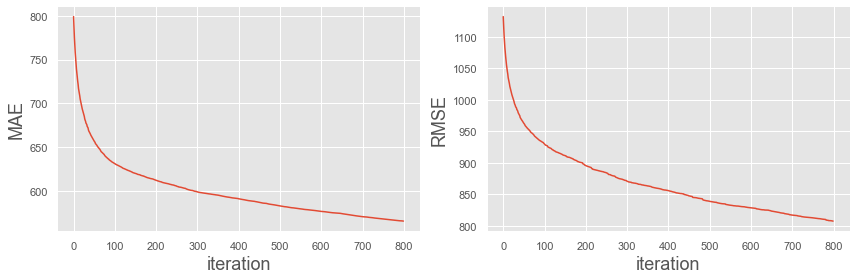

(662.3059229857178, 1023.3450700389067)

In [33]:
gbm = GBMFromScratch(n_trees=800, max_depth=5)
gbm.fit(X_train, y_train.values)
gbm.visualize_cost()
MAE(y_test, gbm.predict(X_test)), RMSE(y_test, gbm.predict(X_test))


| depth\n_trees | 100 | 200 | 400 | 800 |     
| :-: | :-: | :-: | :-: | :-: |             
| 1 | 750.5  | 735.8 | 720.2 | 704.4 | 
| 3 | 699.5 | 684.1 | 673.9 | 668.3 | 
| 5 | 679.2 | 668.7 | 663.4 | 662.2 |
| 7 | 671.5 | 665.6 | | |

| depth\n_trees | 100 | 200 | 400 | 800 |     
| :-: | :-: | :-: | :-: | :-: |            
| 1 |  1133.7 | 1120.6 | 1103.4 | 1085.6 | 
| 3 |  1078.1 | 1059.7 | 1045.1 | 1034.6 |
| 5 |  1053.8 | 1039.8 | 1028.3 | 1023.4 |
| 7 |  1045.2 | 1034.8 | 





### C.5 Revised gradient boosted machine

The following defines revised GBM, which rescales residuals before using in next tree. The `GBM2` class inherents from `GBMFromScratch` class. From the problem description, 

    "..underestimating delivery time is roughly twice as costly as overestimating it."
    
Thus I add an additional coefficient $\eta$ on residuals 

$$e= y-\hat{y} \to \eta(y-\hat{y}) \ \textrm{ if } e > 0, $$ 

i.e. under-estimate delivery time. On the other hand, no change on $e \le 0$. Also, I further consider the MAE metric from positive and negative residuals.

In this case, the boosted machine will amplitude the cost for under-estimate prediction during optimization.

In [55]:
def MAE2(true_y, pred_y):
    under_est = np.mean([abs(true_y[i]-pred_y[i]) for i in range(len(pred_y)) if true_y[i] >= pred_y[i]])
    over_est = np.mean([abs(true_y[i]-pred_y[i]) for i in range(len(pred_y)) if true_y[i] < pred_y[i]])
    return under_est, over_est


class GBM2(GBMFromScratch):    
    def fit(self, x, y, eta = 1.0):
        Fm = np.mean(y)
        self.model = [Fm]
        self.cost = {"MAE": [], "RMSE": []}
        for t in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            res = list(y - Fm)
            
            for i in range(len(res)):
                if res[i] > 0:  # rescale underestimate delivery time
                    res[i] = eta*res[i]
                elif res[i] < 0: # overestimate delivery time
                    res[i] = res[i] 
            
            tree.fit(x, res)

            Fm += self.alpha*tree.predict(x)
            self.model.append(tree)  
            self.cost["MAE"].append(MAE(y, self.predict(x)))
            self.cost["RMSE"].append(RMSE(y, self.predict(x)))

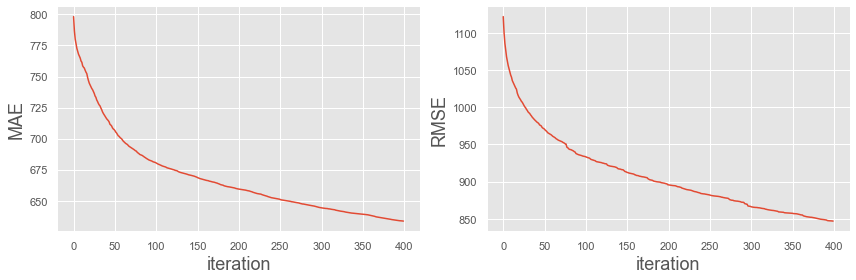

MAE: 702.1916896245745 , RMSE: 1034.087488956366
MAE > 0 and < 0: (808.3085175939058, 640.1063162474153)


In [62]:
gbm2 = GBM2(n_trees=400, max_depth=5)
gbm2.fit(X_train, y_train.values, eta=2.0)
gbm2.visualize_cost()
print ("MAE:", MAE(y_test, gbm2.predict(X_test)), ", RMSE:", RMSE(y_test, gbm2.predict(X_test)))
print ("MAE > 0 and < 0:", MAE2(y_test, gbm2.predict(X_test)))


| depth | n_trees | model | total MAE | MAE (e > 0) | MAE (e < 0) | 
| :-: | :-: | :-: | :-: | :-: | :-: |             
| 3 | 400 | GBM |  673.9 | 853.7 | 502.8 |
| 3 | 400 | rGBM ($\eta$ = 1.5) | 674.0 | 851.8 | 571.1 |
| 3 | 400 | rGBM ($\eta$ = 2.0) | 702.5 | 823.8 | 629.5 |
| 5 | 400 | GBM |  663.4 |  831.4 | 514 |
| 5 | 400 | rGBM ($\eta$ = 1.5) | 677.9 | 822.1 | 573.5 |
| 5 | 400 | rGBM ($\eta$ = 2.0) | 702.4 | 807.8 | 641.1 |
| 5 | 800 | GBM | 662.2 | 819.7 | 528.9 |
| 5 | 800 | rGBM ($\eta$ = 2.0) | 704.2 | 802.6 | 647.4 |

From the above, I will choose depth = 5, n_trees = 400 and $\eta=2$ as the optimal rGBM to compare others models.

### C.6 Model comparison

We can summarize all the model performance and compare below

| model | MAE | RMSE | 
| :-: | :-: | :-: |           
| Lasso | 720.6 | 1098.4 | 
| random forest |  696.8 | 1075.6 |
| DNN | 703.2 | 1086.5 |
| GBM | 662.2 | 1023.3 | 
| rGBM | 702.4 | 1034.0 |

We see the GBM outperforms to others. However, if further individually considering MAE by under-esimate events and over-estimate events, rGBM lower cost on under-estimate events, though raise cost on over-estimate events. By trade-off at $\eta$, rGBM may outpeform GBM. 

In the following we can compare how predictions from GBM and rGBM relates to true values on delivery time:

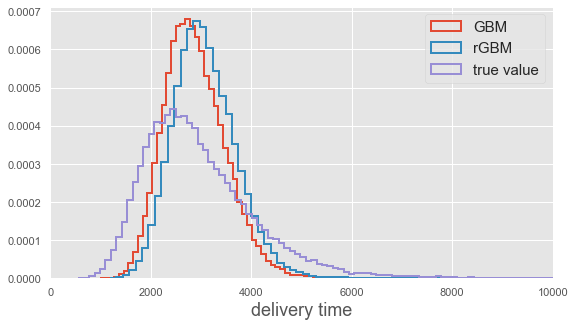

In [114]:
plt.figure(figsize=(9,5))
plt.hist(gbm.predict(X_test), bins = 100, histtype='step', density=True,  label = "GBM", linewidth=2)
plt.hist(gbm2.predict(X_test), bins = 100, histtype='step', density=True, label = "rGBM", linewidth=2)
plt.hist(y_test, bins = 500, histtype='step', density=True, label = "true value", linewidth=2)
plt.xlim(0, 10000)
plt.xlabel("delivery time", fontsize=18)
plt.legend(fontsize=15)
plt.show()

rGBM with correction on $y-\hat{y}$ raises delivery time to higher, to lower impact of underestimating delivery time.

## D. Prediction

Note data from **predict_data.csv** has `delivery_id` and `platform`, which we need to remove before implement to prediction since they don't exist in training data. Also, there are missing values in the data, so we need to use LabelEncoder generated in training data to convert `store_primary_category`, `store_primary_category` and `order_protocol`, also imputation on `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` and `estimated_store_to_consumer_driving_duration`.

In [34]:
pred_df.isnull().sum()

market_id                                        250
created_at                                         0
store_id                                           0
store_primary_category                          1343
order_protocol                                   283
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
platform                                           0
dtype: int64

In [35]:
pred_df = pred_df.dropna(axis=0, subset=['created_at'])
pred_df = get_time_features(pred_df)

pred_df["store_primary_category"] = store_category_encoder.fit_transform(pred_df["store_primary_category"])
pred_df["order_protocol"] = order_protocol_encoder.fit_transform(pred_df["order_protocol"])
pred_df["market_id"] = market_id_encoder.fit_transform(pred_df["market_id"])
pred_df2 = pred_df.fillna(value=fillna_values)

In [36]:
delivery_id = pred_df2['delivery_id'].tolist()
pred_df2 = pred_df2.drop(['delivery_id', 'platform'], axis=1)

In [37]:
pred_df2.shape, len(delivery_id), X_test.shape

((54778, 19), 54778, (39484, 19))

In [38]:
pred_df2.head()

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,month,day,hour,min,weekday
0,2,5477,71,0,5,7500,4,800,1800,4.0,4.0,4.0,446,670.0,2,25,2,22,2
1,2,5477,71,0,5,7100,4,800,1500,4.0,1.0,1.0,446,446.0,2,25,1,14,2
2,3,5477,66,0,4,4500,2,750,1500,9.0,7.0,6.0,446,504.0,2,22,2,27,6
3,2,5477,71,0,1,1700,1,1400,1400,3.0,3.0,3.0,446,687.0,2,25,1,32,2
4,0,2841,37,0,2,3150,2,1525,1625,4.0,4.0,4.0,446,528.0,2,24,5,20,1


In [39]:
pred_df2.isnull().sum()

market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
month                                           0
day                                             0
hour                                            0
min                                             0
weekday                                         0
dtype: int64

In [852]:
X_test.shape, len(rfReg.predict(X_test))

((35859, 19), 35859)

In [44]:
gbm_pred = gbm.predict(pred_df2.values)
submit_df = pd.DataFrame({"delivery_id": delivery_id, "pred_delivery_time": gbm_pred})
submit_df.to_csv("data_to_predict_gbm.csv")

In [42]:
len(gbm_pred), len(delivery_id)

(54778, 54778)

In [67]:
gbm2_pred = gbm2.predict(pred_df2.values)
submit_df2 = pd.DataFrame({"delivery_id": delivery_id, "pred_delivery_time": gbm2_pred})
submit_df2.to_csv("data_to_predict_gbm2.csv")

In [69]:
submit_df2.head()

,delivery_id,pred_delivery_time
0,194096,3711.310091
1,236895,2940.616554
2,190868,3436.083397
3,183076,3494.792406
4,186200,2855.841294


In [70]:
submit_df.head()

,delivery_id,pred_delivery_time
0,194096,3426.090814
1,236895,2574.004996
2,190868,3237.302239
3,183076,3574.124843
4,186200,2585.680135
